Begun 5/2/24

The goal of this notebook is to tweak some of the power law noise fits in nb12 and test the more realistic case of not having noise in the reference maps. For the likelihood, I am just taking the maximum instead of doing a Gaussian fit to see if that is unbiased in recovering the angle at least.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def sample_likelihood_and_max(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the max of the likelihood
       without any fitting for a Gaussian
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = estimator_likelihood(angle,estimator,covariance,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # I don't expect there to be issues with multiple max values
    max_index = np.where(norm_sampled_likelihood == np.max(norm_sampled_likelihood))[0][0]
    like_max_deg = np.rad2deg(angles_rad[max_index])
    
    return like_max_deg

def sample_null_eb_likelihood_and_max(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the max of the likelihood
       without any fitting for a Gaussian
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)

    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    max_index = np.where(norm_sampled_likelihood == np.max(norm_sampled_likelihood))[0][0]
    like_max_deg = np.rad2deg(angles_rad[max_index])
    
    return like_max_deg

In [4]:
def calc_rho_mapspace(rot_Q,rot_U,unrot_Q,unrot_U):
    """
    Uses the Keck map space estimator for the angle (neglecting in-pixel correlations between Q and U)
    This estimator has been adjusted to use the same coordinate system as our angle estimator.
    It also has a factor of 2 difference because of how Q and U are defined relative to the power spectrum estimator.
    """
    rho = np.sum((-1*unrot_Q*unrot_U + rot_Q*unrot_U)+(-1*unrot_Q*rot_U + unrot_Q*unrot_U))/np.sum(unrot_U**2+unrot_Q**2)
    rho /= 2.0 # To measure the same angle as the PS estimators
    rho *= 180./np.pi
    return rho

In [5]:
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def load_and_filter_depth1_with_T(depth1_path, plot=False):
    print(depth1_path)
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
        
    # Apodize and filter depth-1
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=plot)
    depth1_TEB = enmap.map2harm(depth1_maps*depth1_mask, normalize = "phys")
    
    w2 = np.mean(depth1_mask**2)
        
    # Not sure if I need this, but it is the default behavior in kfilter_map in nawrapper
    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(depth1_maps)):
            wy, wx = enmap.calc_window(depth1_maps[i].shape)
            depth1_TEB[i] /= wy[:, np.newaxis]
            depth1_TEB[i] /= wx[np.newaxis, :]
        
    ly, lx = depth1_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = depth1_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB[0], filtered_TEB[1], filtered_TEB[2], w2

def spectrum_from_maps(map1, map2, b_ell_binned, w2, lmax, bin_size):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))
    
    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2
    
    modlmap = map1.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= b_ell_binned**2

    return centers, binned, bincount

In [6]:
# Loading in depth-1 map, calculating power spectra without filtering to get noise, and
# fitting an interpolation to get a spectrum for every ell with which to generate noise maps
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

unpixwin = True
kx_cut = 90 # Do we want to turn off filtering here? Not now - want it to be realistic to what we will have
ky_cut = 50
lmax = 2500
bin_size = 25
    
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[0]

depth1_T, depth1_E, depth1_B, w2 = load_and_filter_depth1_with_T(depth1_path)

# Doing filtering and binning as normal
ell_b, depth1_TT, bincount = spectrum_from_maps(depth1_T,depth1_T,1.0,w2,lmax,bin_size)
_, depth1_EE, _ = spectrum_from_maps(depth1_E,depth1_E,1.0,w2,lmax,bin_size)
_, depth1_BB, _ = spectrum_from_maps(depth1_B,depth1_B,1.0,w2,lmax,bin_size)

/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa4_f150_map.fits


In [7]:
from scipy.optimize import curve_fit
def power_law(x,a,b):
    return a*np.power(x,b)

In [8]:
# Fitting power law to TT, EE, BB to everything after the first five points (35 for TT)
TT_fit, _ = curve_fit(f=power_law, xdata=ell_b[35:], ydata=depth1_TT[35:], p0=[0,0],bounds=(-np.inf,np.inf))
EE_fit, _ = curve_fit(f=power_law, xdata=ell_b[5:], ydata=depth1_EE[5:], p0=[0,0],bounds=(-np.inf,np.inf))
BB_fit, _ = curve_fit(f=power_law, xdata=ell_b[5:], ydata=depth1_BB[5:], p0=[0,0],bounds=(-np.inf,np.inf))

[ 1.78790216e+13 -4.12596720e+00]


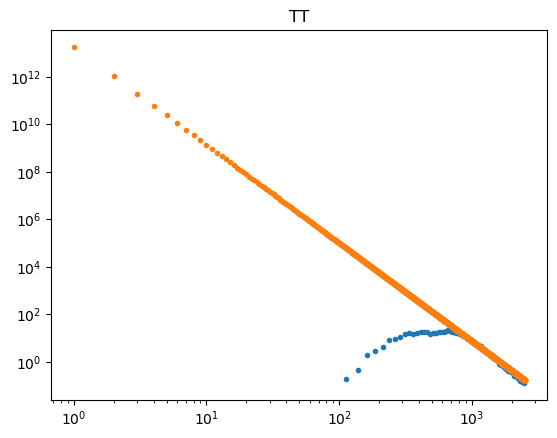

[ 1.15638532e+03 -1.08471351e+00]


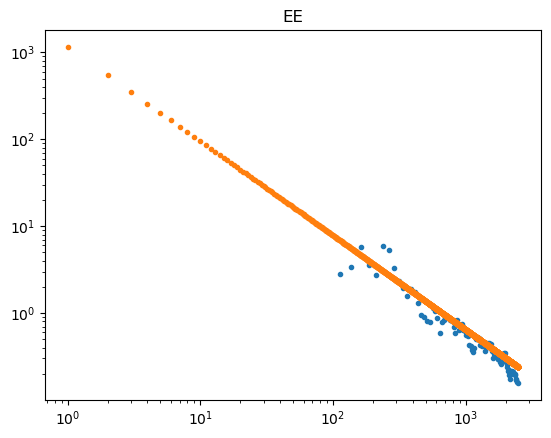

[ 1.78790216e+13 -4.12596720e+00]


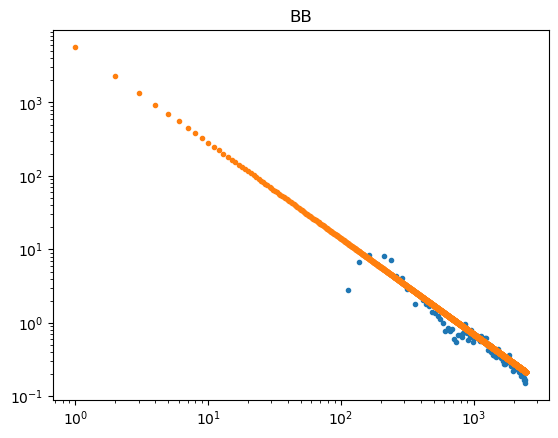

In [9]:
# Checking fits
print(TT_fit)
plt.loglog(ell_b, depth1_TT, marker=".", ls="none",label = "TT")
plt.loglog(np.arange(1,2501), power_law(np.arange(1,2501), *TT_fit), marker=".", ls="none",label = "fit")
plt.title('TT')
plt.show()
plt.close()
print(EE_fit)
plt.loglog(ell_b, depth1_EE, marker=".", ls="none",label = "EE")
plt.loglog(np.arange(1,2501), power_law(np.arange(1,2501), *EE_fit), marker=".", ls="none",label = "fit")
plt.title('EE')
plt.show()
plt.close()
print(TT_fit)
plt.loglog(ell_b, depth1_BB, marker=".", ls="none",label = "BB")
plt.loglog(np.arange(1,2501), power_law(np.arange(1,2501), *BB_fit), marker=".", ls="none",label = "fit")
plt.title('BB')
plt.show()
plt.close()

In [10]:
noise_TT = np.zeros(arr_len)
noise_EE = np.zeros(arr_len)
noise_BB = np.zeros(arr_len)
# Starting at ell=90 to miss regions that should be filtered out
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
noise_TT[90:2501] = power_law(np.arange(90,2501), *TT_fit)
noise_EE[90:2501] = power_law(np.arange(90,2501), *EE_fit)
noise_BB[90:2501] = power_law(np.arange(90,2501), *BB_fit)

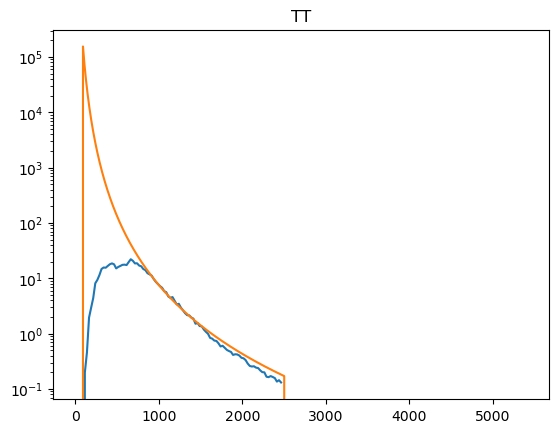

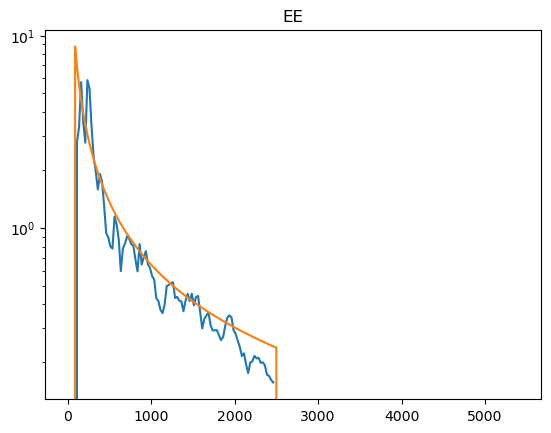

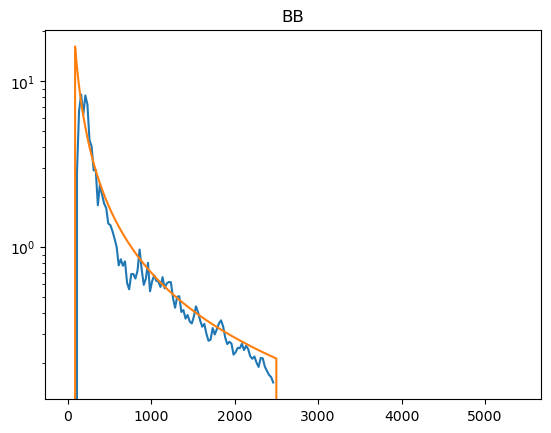

In [11]:
plt.title("TT")
plt.semilogy(ell_b,depth1_TT)
plt.semilogy(range(arr_len),noise_TT)
plt.show()
plt.close()
plt.title("EE")
plt.semilogy(ell_b,depth1_EE)
plt.semilogy(range(arr_len),noise_EE)
plt.show()
plt.close()
plt.title("BB")
plt.semilogy(ell_b,depth1_BB)
plt.semilogy(range(arr_len),noise_BB)
plt.show()
plt.close()

In [12]:
# Doing 500 sims of full sky maps plus noise for the rotated map ONLY 
# with an ell range of 200-1000 and a rot angle of 7 deg
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Doing the rotation in PS space instead of map space

# Compared to nb12, adjusts starting ell for noise, only has noise in rotated maps, and only
# takes the max of the likelihood instead of fitting a Gaussian to it
min_ell = 200
max_ell = 1000
N_sims = 500
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[7.0])
noise_seeds = np.random.randint(0,10000,size=rot_degs.size)
for i in tqdm(range(N_sims)):
    rot_deg = rot_degs[i]
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = i # Ensures it is different each time
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at rotated angle to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise with a random seed
    np.random.seed(noise_seeds[i])
    noise_maps = hp.sphtfunc.synfast((noise_TT, np.zeros(noise_TT.size), noise_EE, noise_BB),nside)
    # Adding them together for rot maps ONLY
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    # Changing the fit range slightly to account for larger starting angle
    # Using larger number of points to ensure good angle resolution
    fit_values = sample_likelihood_and_max(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-10.0,angle_max_deg=20.0,num_pts=100000)

    null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=20.0,num_pts=100000)
    # This should again be zero since there is no noise anymore in the unrotated maps
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=10.0,num_pts=100000)
    
    # Changing this back to ClTT_unrot instead of ClTT_rot so that it should again be an assessment
    # of whether the recovery of the CAMB spectra by anafast is unbiased (since there is no noise in unrot maps to
    # make this meaningless anymore)
    tt_bias_outputs.append(np.mean(ClTT_unrot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles) # Only angle returned now
output_null_eb_angles_only = np.array(output_null_eb_angles)
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:42:59<00:00, 19.56s/it]


Median of full sky percent error, map based estimator: -4.217810218554373
Mean of full sky percent error, map based estimator: -3.746220125249073
Std dev of full sky percent error, map based estimator: 22.774107839905177


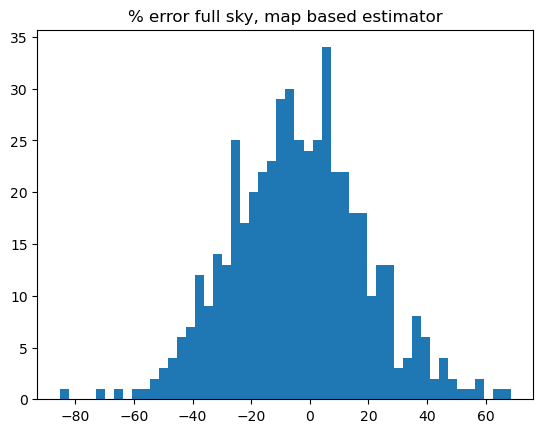

Median of full sky percent error: -2.655455125979854
Mean of full sky percent error: -2.314463144631465
Std dev of full sky percent error: 28.342359958037754


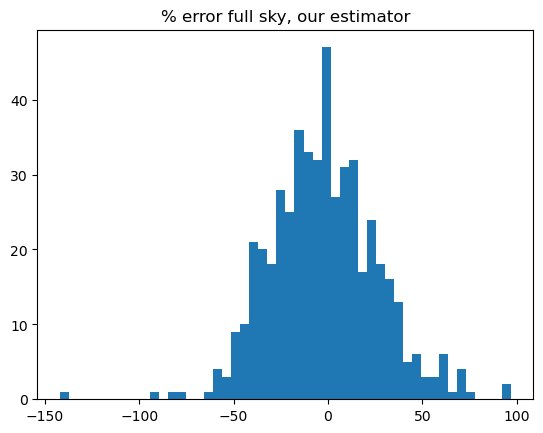

Median of full sky percent error EB estimator: 11.14039711825689
Mean of full sky percent error EB estimator: -22.49944499444994
Std dev of full sky percent error EB estimator: 205.11702698200708


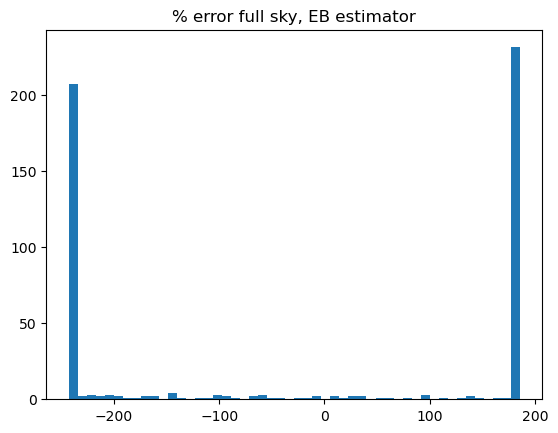

Median of full sky angles Unrot EB estimator: -0.00010000100000873147
Mean of full sky angles Unrot EB estimator: -6.16006160056557e-05
Std dev of full sky angles Unrot EB estimator: 0.001810820538068984


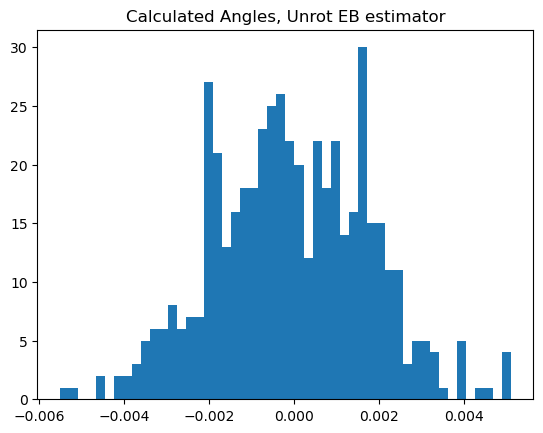

Median of full sky mean TT ratio: 0.999989788146664
Mean of full sky mean TT ratio: 1.0000015434787939
Std dev of full sky mean TT ratio: 0.0015396073185928365


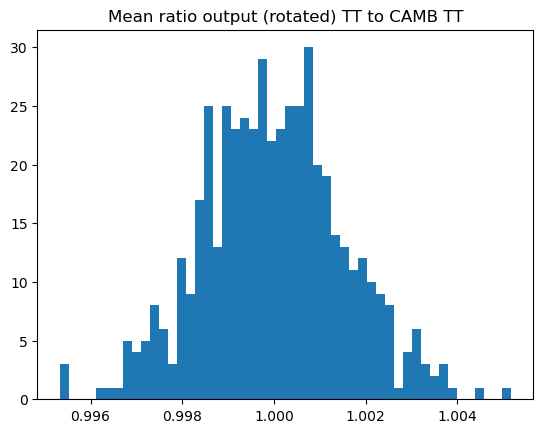

In [13]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
#plt.hist(percent_diff_eb,bins=20,range=(-2,2))
#plt.title("% error full sky, EB estimator, ignoring possible outliers")
#plt.show()
#plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

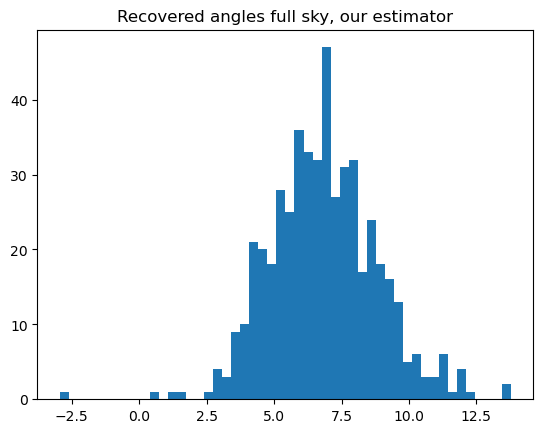

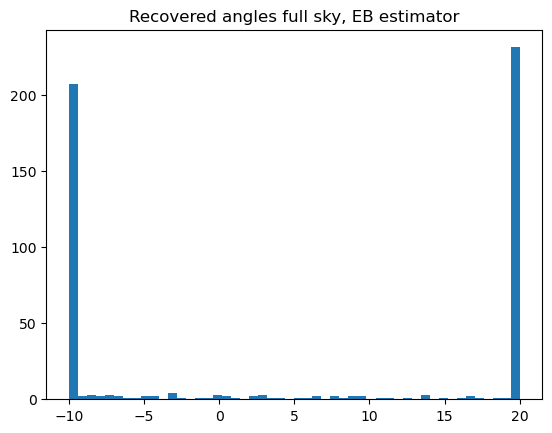

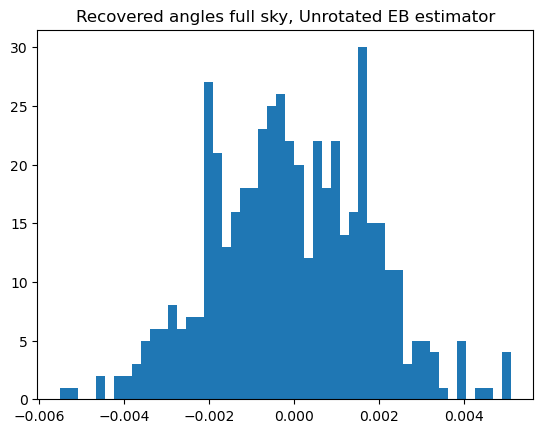

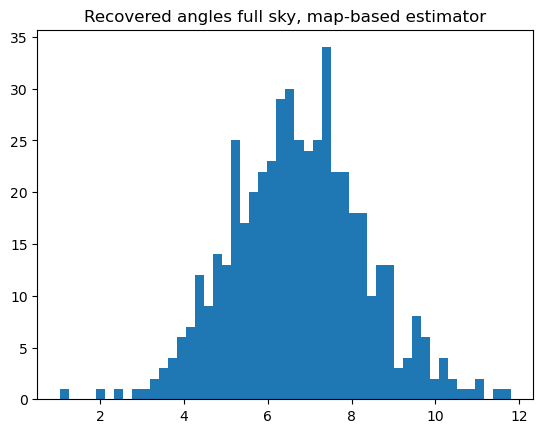

In [14]:
# Plotting the angles by themselves instead of percent difference
plt.hist(output_angles_only,bins=50)
plt.title("Recovered angles full sky, our estimator")
plt.show()
plt.close()
plt.hist(output_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, EB estimator")
plt.show()
plt.close()
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, Unrotated EB estimator")
plt.show()
plt.close()
plt.hist(output_mapspace_angles,bins=50)
plt.title("Recovered angles full sky, map-based estimator")
plt.show()
plt.close()

In [15]:
output_spectra = np.array(output_spectra)

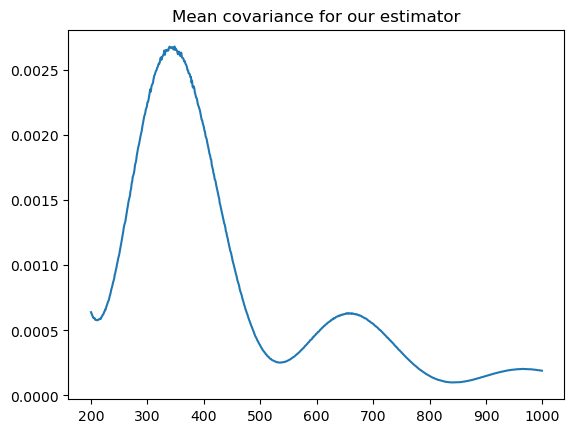

In [22]:
mean_EB = np.mean(output_spectra[:,10],axis=0)
mean_EB_rot = np.mean(output_spectra[:,4],axis=0)
mean_EB_cross12 = np.mean(output_spectra[:,16],axis=0)
mean_EB_cross21 = np.mean(output_spectra[:,22],axis=0)
mean_estimator = np.mean(output_spectra[:,16] - output_spectra[:,22], axis=0)
mean_EE_unrot = np.mean(output_spectra[:,7],axis=0)
mean_EE_rot = np.mean(output_spectra[:,1],axis=0)
mean_EE_cross12 = np.mean(output_spectra[:,13],axis=0)
mean_EE_cross21 = np.mean(output_spectra[:,19],axis=0)
mean_BB_unrot = np.mean(output_spectra[:,8],axis=0)
mean_BB_rot = np.mean(output_spectra[:,2],axis=0)
mean_BB_cross12 = np.mean(output_spectra[:,14],axis=0)
mean_BB_cross21 = np.mean(output_spectra[:,20],axis=0)

mean_covariance = ((mean_EE_rot*mean_BB_unrot+mean_EB_cross12**2) \
                  + (mean_EE_unrot*mean_BB_rot+mean_EB_cross21**2) \
                  - 2*(mean_EE_cross12*mean_BB_cross12+mean_EB_rot*mean_EB))

plt.title("Mean covariance for our estimator")
plt.plot(ell_hp,mean_covariance)
plt.show()
plt.close()

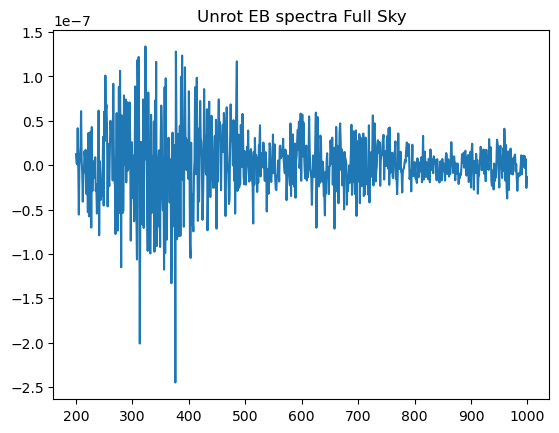

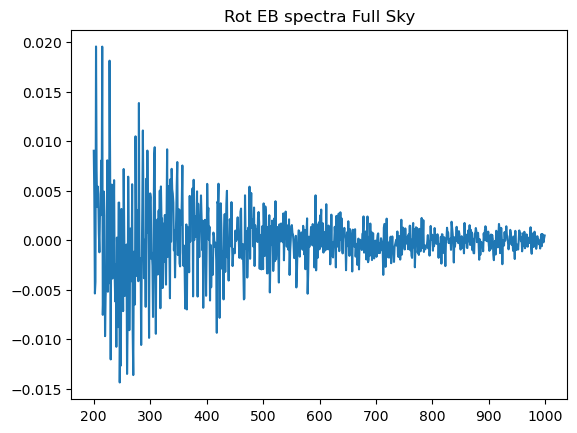

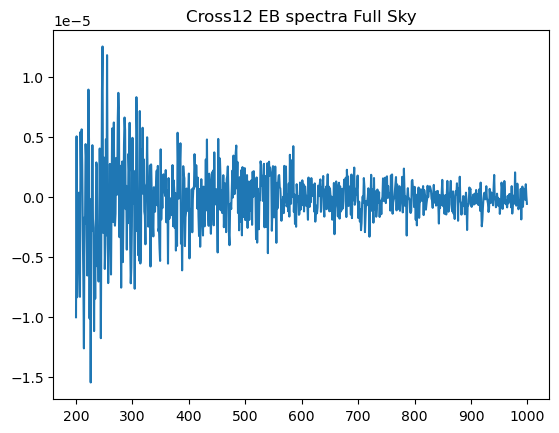

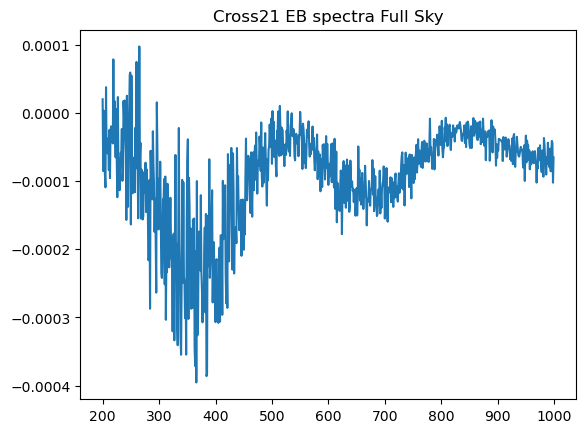

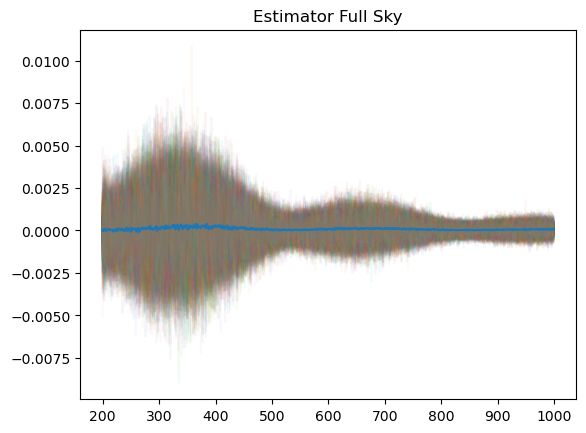

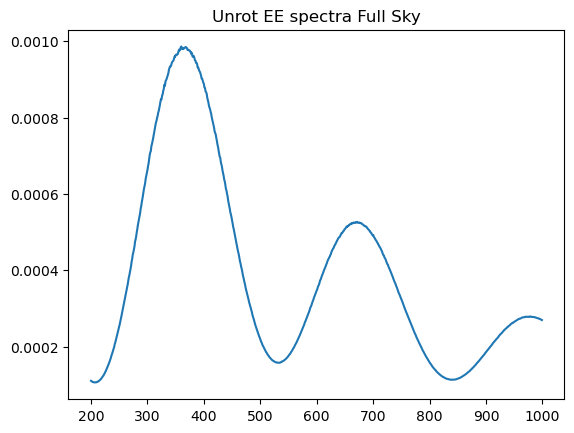

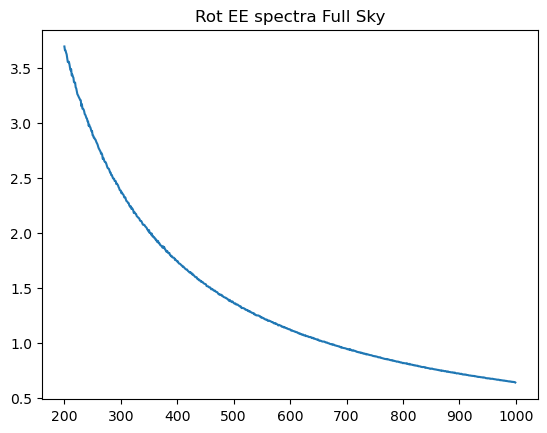

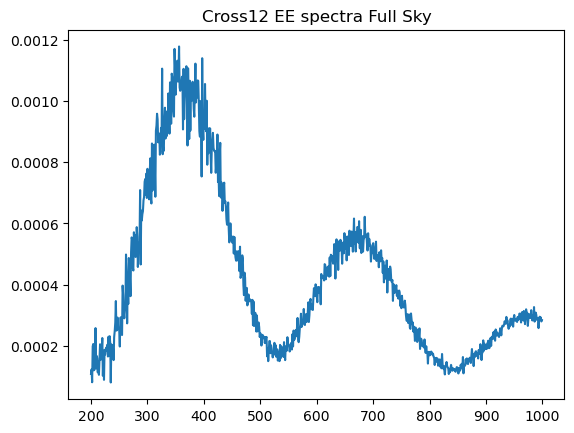

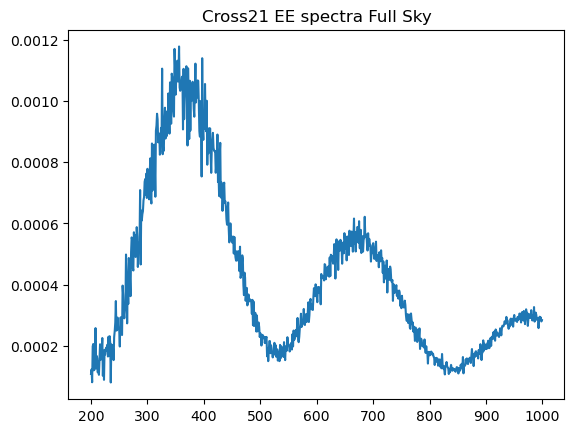

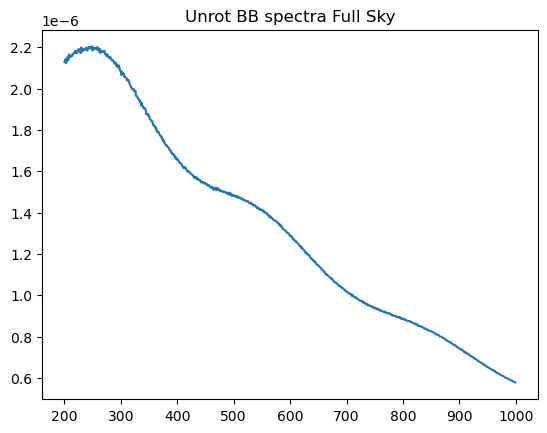

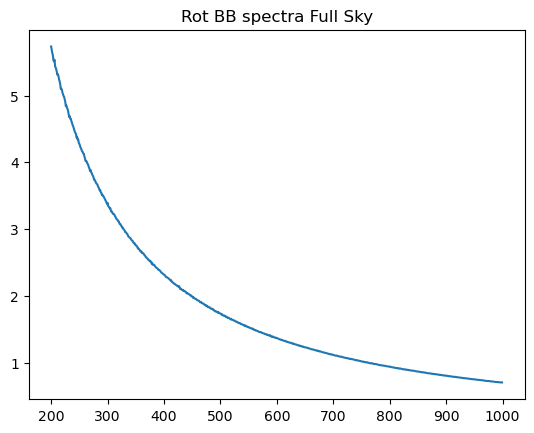

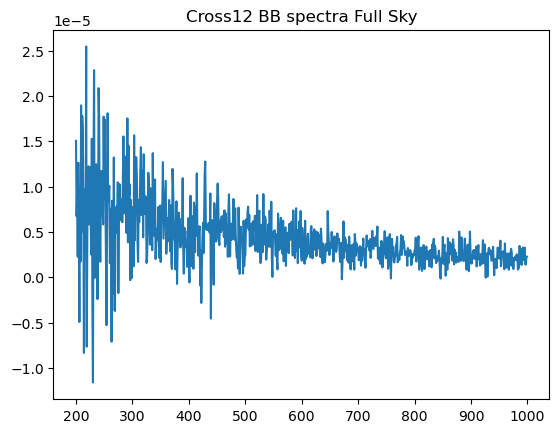

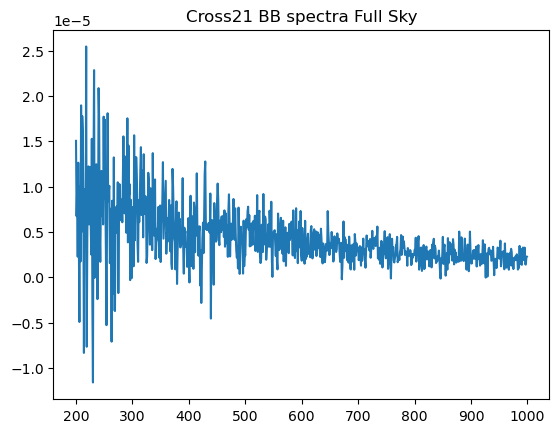

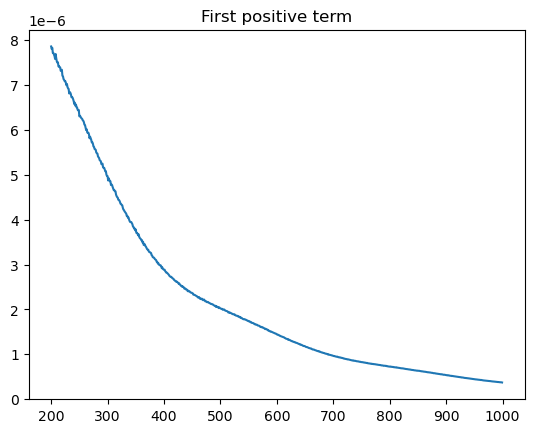

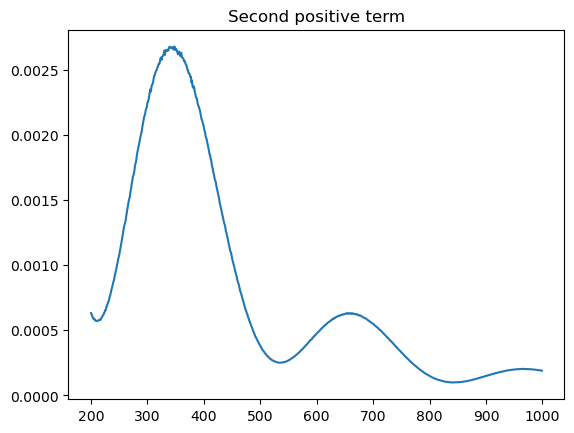

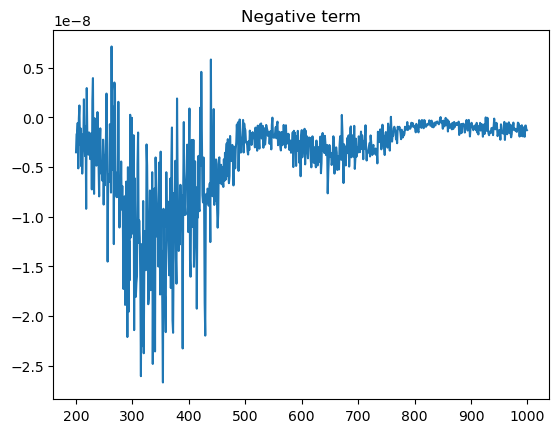

In [25]:
# Plotting all spectra separately to understand what is happening with covariance's structure

# EB Spectra
plt.title("Unrot EB spectra Full Sky")
plt.plot(ell_hp,mean_EB)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Rot EB spectra Full Sky")
plt.plot(ell_hp,mean_EB_rot)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Cross12 EB spectra Full Sky")
plt.plot(ell_hp,mean_EB_cross12)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Cross21 EB spectra Full Sky")
plt.plot(ell_hp,mean_EB_cross21)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

# Estimator
for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][16]-output_spectra[i][22],alpha=0.05)
plt.title("Estimator Full Sky")
plt.plot(ell_hp,mean_estimator)
plt.show()
plt.close()

# EE Spectra
plt.title("Unrot EE spectra Full Sky")
plt.plot(ell_hp,mean_EE_unrot)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Rot EE spectra Full Sky")
plt.plot(ell_hp,mean_EE_rot)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Cross12 EE spectra Full Sky")
plt.plot(ell_hp,mean_EE_cross12)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Cross21 EE spectra Full Sky")
plt.plot(ell_hp,mean_EE_cross21)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

# BB Spectra
plt.title("Unrot BB spectra Full Sky")
plt.plot(ell_hp,mean_BB_unrot)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Rot BB spectra Full Sky")
plt.plot(ell_hp,mean_BB_rot)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Cross12 BB spectra Full Sky")
plt.plot(ell_hp,mean_BB_cross12)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Cross21 BB spectra Full Sky")
plt.plot(ell_hp,mean_BB_cross21)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

# Plotting individual parts of the mean covariance
plt.title("First positive term")
plt.plot(ell_hp, mean_EE_rot*mean_BB_unrot+mean_EB_cross12**2)
plt.show()
plt.close()
plt.title("Second positive term")
plt.plot(ell_hp, mean_EE_unrot*mean_BB_rot+mean_EB_cross21**2)
plt.show()
plt.close()
plt.title("Negative term")
plt.plot(ell_hp, -2*(mean_EE_cross12*mean_BB_cross12+mean_EB_rot*mean_EB))
plt.show()
plt.close()

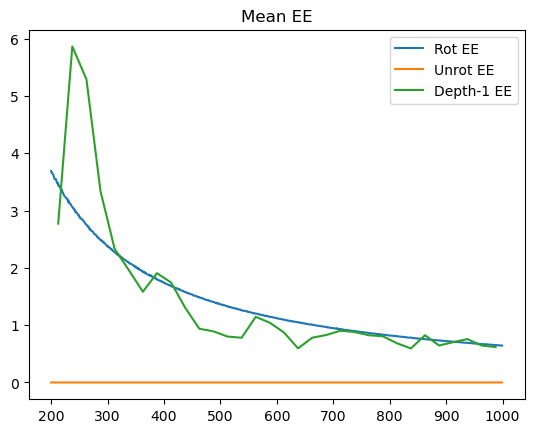

In [17]:
plt.title("Mean EE")
plt.plot(ell_hp,mean_EE_rot,label='Rot EE')
plt.plot(ell_hp,mean_EE_unrot,label="Unrot EE")
plt.plot(ell_b[8:40],depth1_EE[8:40],label='Depth-1 EE')
plt.legend()
plt.show()
plt.close()

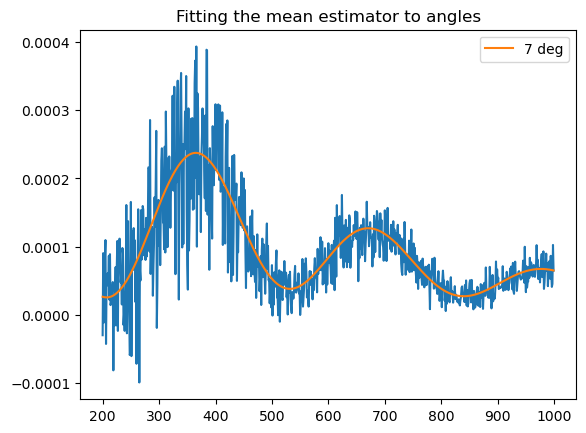

In [18]:
plt.title("Fitting the mean estimator to angles")
plt.plot(ell_hp,mean_estimator)
plot_angle = np.deg2rad(7.0)
plt.plot(ell_hp,1.0*ClEE[min_ell:max_ell]*np.sin(2*plot_angle),label='7 deg')
#plt.plot(ell_hp,0.5*ClEE[min_ell:max_ell]*np.sin(4*plot_angle))
plt.legend()
plt.show()
plt.close()

In [19]:
angles_deg = np.linspace(-60.0,60.0,num=100000)
angles_rad = np.deg2rad(angles_deg)
    
bin_sampled_likelihood = []
    
for angle in angles_rad:
    likelihood = estimator_likelihood(angle,mean_estimator,mean_covariance,ClEE[min_ell:max_ell])
    bin_sampled_likelihood.append(likelihood)

norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)

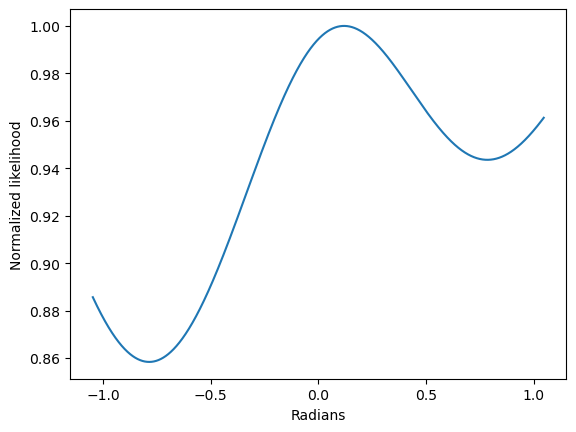

In [20]:
plt.plot(angles_rad,norm_sampled_likelihood)
plt.ylabel("Normalized likelihood")
plt.xlabel("Radians")
plt.show()
plt.close()

In [21]:
index = np.where(norm_sampled_likelihood == np.max(norm_sampled_likelihood))[0][0]
print(index)
print(np.rad2deg(angles_rad[index]))

55713
6.856268562685628


In order to make sure that this recovery of the angle by using the max of the estimator works the way we expect, I'm going to run two additional tests:
1. Try shrinking the noise by a factor of 100 and make sure that the distribution of recovered angles drops accordingly.
2. Use a random distribution of angles and make sure it is still unbiased (that is, mean/stddev is still small).

In [26]:
# Doing 500 sims of full sky maps plus noise for the rotated map ONLY 
# with an ell range of 200-1000 and a rot angle of 7 deg
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Doing the rotation in PS space instead of map space

# Compared to above, shrinks noise by a factor of 100 to make sure that the distribution of angles gets narrower
max_ell = 1000
N_sims = 500
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[7.0])
noise_seeds = np.random.randint(0,10000,size=rot_degs.size)
for i in tqdm(range(N_sims)):
    rot_deg = rot_degs[i]
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = i # Ensures it is different each time
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at rotated angle to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise with a random seed
    np.random.seed(noise_seeds[i])
    # Using smaller noise!!
    noise_maps = hp.sphtfunc.synfast((noise_TT/100., np.zeros(noise_TT.size), noise_EE/100., noise_BB/100.),nside)
    # Adding them together for rot maps ONLY
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    # Changing the fit range slightly to account for larger starting angle
    # Using larger number of points to ensure good angle resolution
    fit_values = sample_likelihood_and_max(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-10.0,angle_max_deg=20.0,num_pts=100000)

    null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=20.0,num_pts=100000)
    # This should again be zero since there is no noise anymore in the unrotated maps
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=10.0,num_pts=100000)
    
    # Changing this back to ClTT_unrot instead of ClTT_rot so that it should again be an assessment
    # of whether the recovery of the CAMB spectra by anafast is unbiased (since there is no noise in unrot maps to
    # make this meaningless anymore)
    tt_bias_outputs.append(np.mean(ClTT_unrot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles) # Only angle returned now
output_null_eb_angles_only = np.array(output_null_eb_angles)
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:39:06<00:00, 19.09s/it]


Median of full sky percent error, map based estimator: -1.4888898337909215
Mean of full sky percent error, map based estimator: -1.4438321104926881
Std dev of full sky percent error, map based estimator: 2.411014546722582


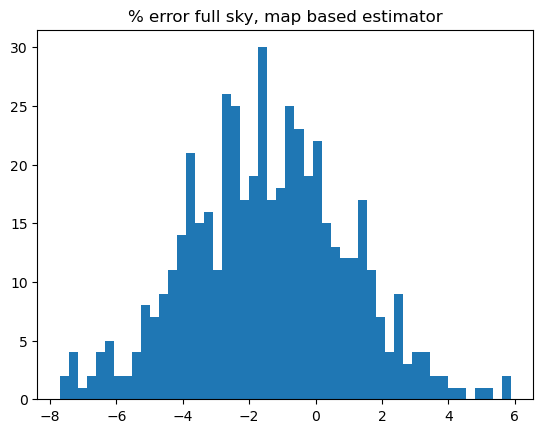

Median of full sky percent error: -0.6775782043534763
Mean of full sky percent error: -0.6416892740356162
Std dev of full sky percent error: 2.9448216633028945


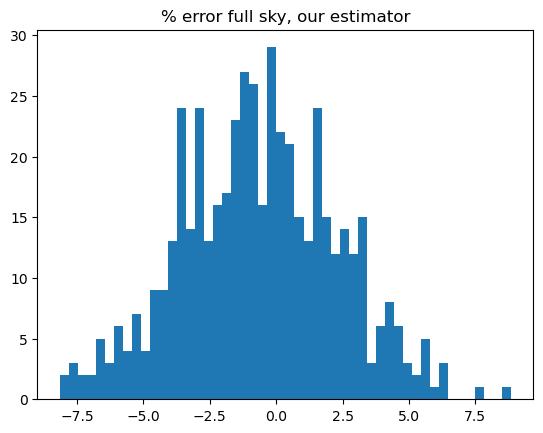

Median of full sky percent error EB estimator: -0.27900279002791095
Mean of full sky percent error EB estimator: 0.008922946372301907
Std dev of full sky percent error EB estimator: 17.36197971341586


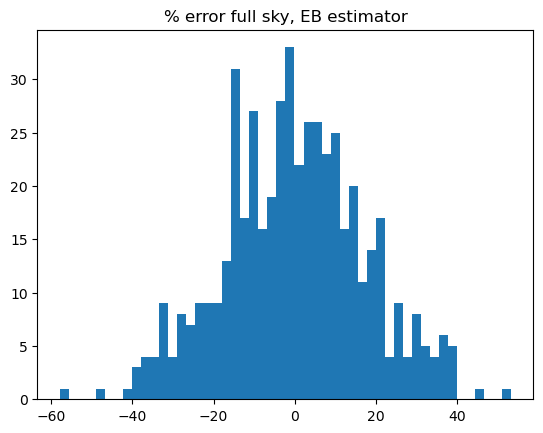

Median of full sky angles Unrot EB estimator: -0.00010000100000873147
Mean of full sky angles Unrot EB estimator: -6.16006160056557e-05
Std dev of full sky angles Unrot EB estimator: 0.001810820538068984


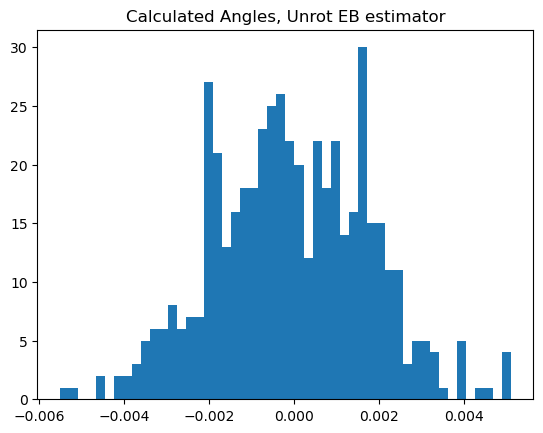

Median of full sky mean TT ratio: 0.999989788146664
Mean of full sky mean TT ratio: 1.0000015434787939
Std dev of full sky mean TT ratio: 0.0015396073185928365


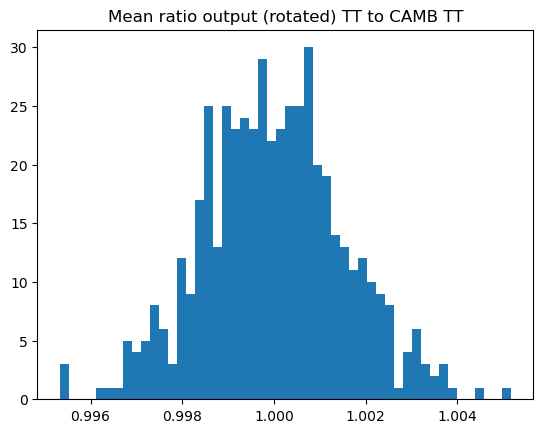

In [27]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

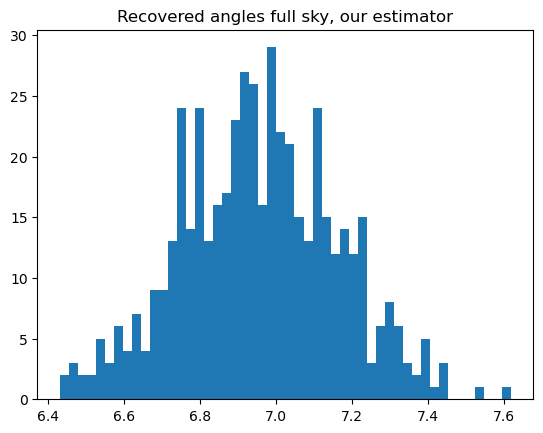

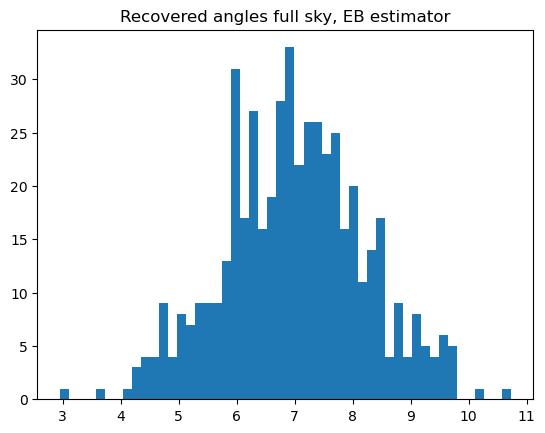

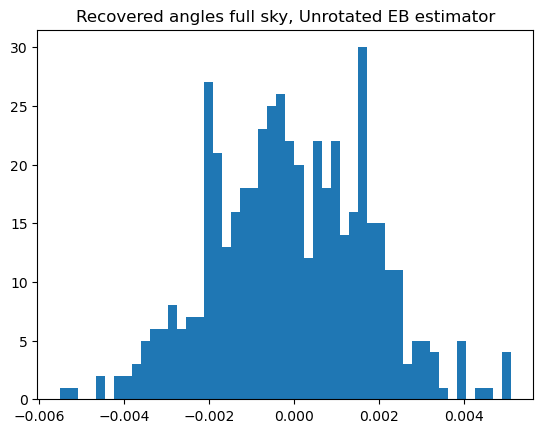

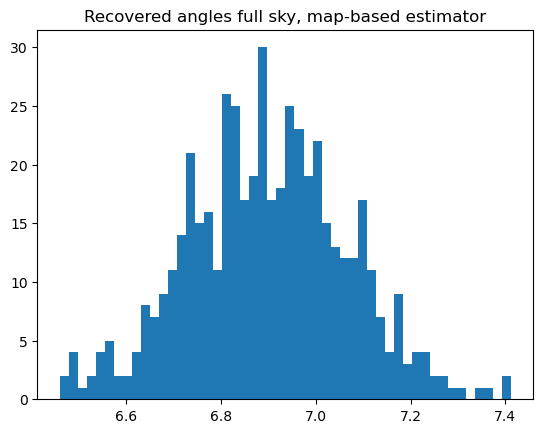

In [28]:
# Plotting the angles by themselves instead of percent difference
plt.hist(output_angles_only,bins=50)
plt.title("Recovered angles full sky, our estimator")
plt.show()
plt.close()
plt.hist(output_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, EB estimator")
plt.show()
plt.close()
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, Unrotated EB estimator")
plt.show()
plt.close()
plt.hist(output_mapspace_angles,bins=50)
plt.title("Recovered angles full sky, map-based estimator")
plt.show()
plt.close()

In [29]:
# Doing 500 sims of full sky maps plus noise for the rotated map ONLY 
# with an ell range of 200-1000 and a rot angle of 1 deg
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Doing the rotation in PS space instead of map space

# Back to using the full noise, but now using a smaller signal of 1 deg to make sure that still seems to
# work
min_ell = 200
max_ell = 1000
N_sims = 500
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
noise_seeds = np.random.randint(0,10000,size=rot_degs.size)
for i in tqdm(range(N_sims)):
    rot_deg = rot_degs[i]
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = i # Ensures it is different each time
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at rotated angle to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise with a random seed
    np.random.seed(noise_seeds[i])
    noise_maps = hp.sphtfunc.synfast((noise_TT, np.zeros(noise_TT.size), noise_EE, noise_BB),nside)
    # Adding them together for rot maps ONLY
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    # Changing the fit range slightly to account for larger starting angle
    # Using larger number of points to ensure good angle resolution
    fit_values = sample_likelihood_and_max(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-10.0,angle_max_deg=20.0,num_pts=100000)

    null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=20.0,num_pts=100000)
    # This should again be zero since there is no noise anymore in the unrotated maps
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=10.0,num_pts=100000)
    
    # Changing this back to ClTT_unrot instead of ClTT_rot so that it should again be an assessment
    # of whether the recovery of the CAMB spectra by anafast is unbiased (since there is no noise in unrot maps to
    # make this meaningless anymore)
    tt_bias_outputs.append(np.mean(ClTT_unrot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles) # Only angle returned now
output_null_eb_angles_only = np.array(output_null_eb_angles)
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:39:04<00:00, 19.09s/it]


Median of full sky percent error, map based estimator: -1.5665242475148167
Mean of full sky percent error, map based estimator: -9.751397767374543
Std dev of full sky percent error, map based estimator: 159.35988070006474


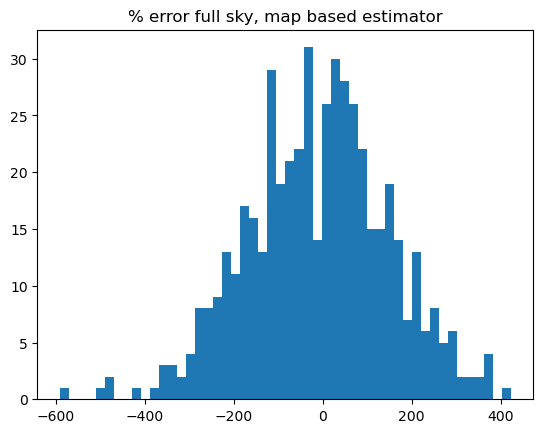

Median of full sky percent error: -8.334083340833498
Mean of full sky percent error: -15.584915849158575
Std dev of full sky percent error: 194.3854019167422


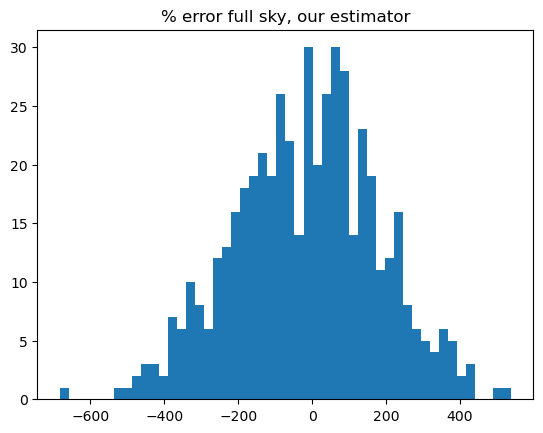

Median of full sky percent error EB estimator: -13.179131791317994
Mean of full sky percent error EB estimator: 369.43551435514354
Std dev of full sky percent error EB estimator: 1439.086005124306


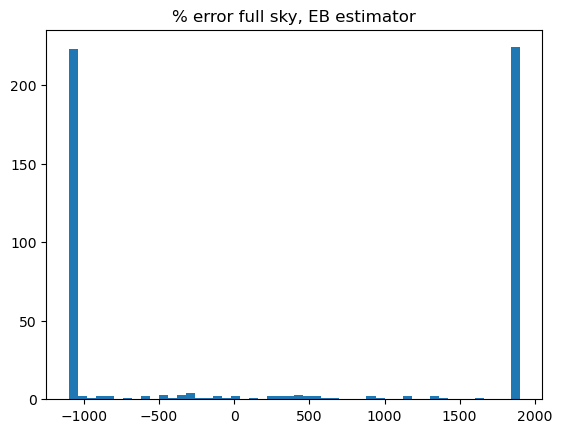

Median of full sky angles Unrot EB estimator: -0.00010000100000873147
Mean of full sky angles Unrot EB estimator: -6.16006160056557e-05
Std dev of full sky angles Unrot EB estimator: 0.001810820538068984


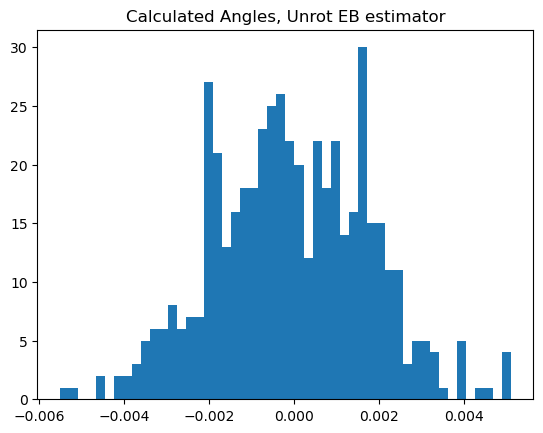

Median of full sky mean TT ratio: 0.999989788146664
Mean of full sky mean TT ratio: 1.0000015434787939
Std dev of full sky mean TT ratio: 0.0015396073185928365


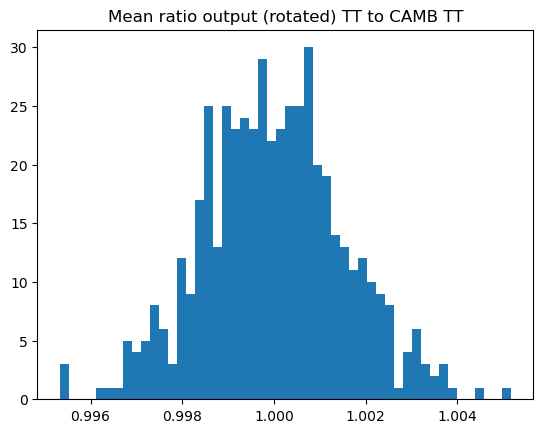

In [30]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

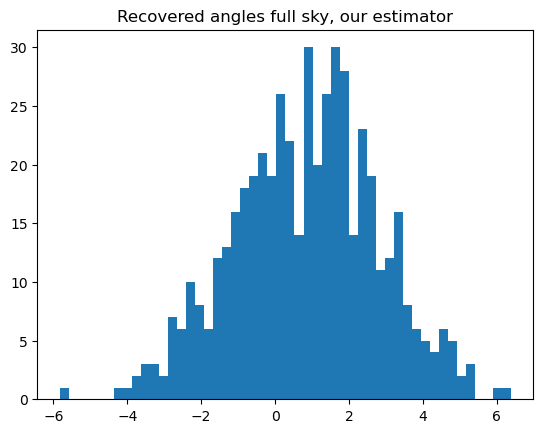

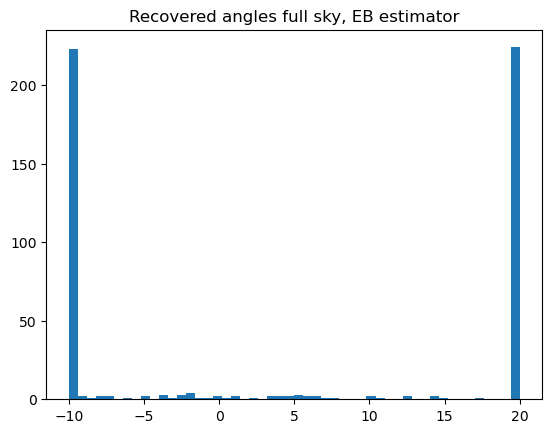

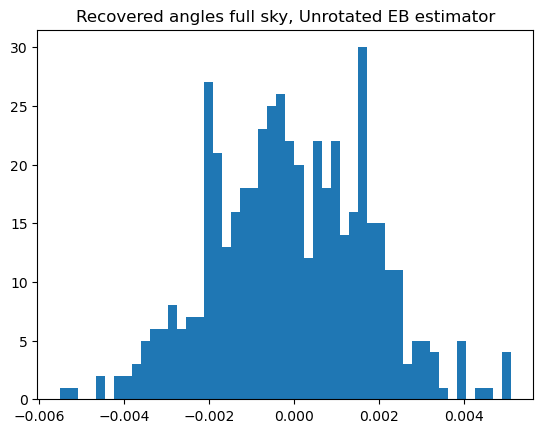

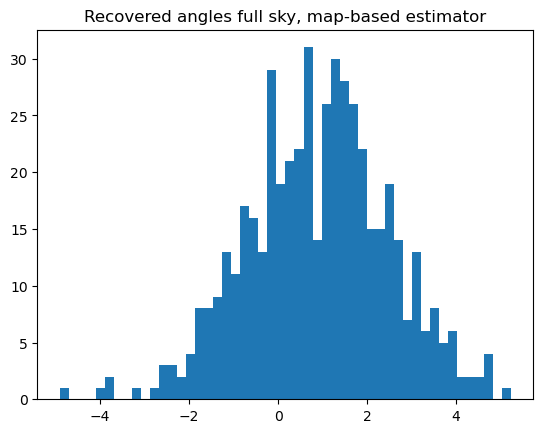

In [31]:
# Plotting the angles by themselves instead of percent difference
plt.hist(output_angles_only,bins=50)
plt.title("Recovered angles full sky, our estimator")
plt.show()
plt.close()
plt.hist(output_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, EB estimator")
plt.show()
plt.close()
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, Unrotated EB estimator")
plt.show()
plt.close()
plt.hist(output_mapspace_angles,bins=50)
plt.title("Recovered angles full sky, map-based estimator")
plt.show()
plt.close()

In [33]:
# Doing 5000 sims of full sky maps plus noise for the rotated map ONLY 
# with an ell range of 200-1000
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Doing the rotation in PS space instead of map space

# Now using random angles and 5000 sims
min_ell = 200
max_ell = 1000
N_sims = 5000
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.random.normal(0, 5, size=(N_sims))
noise_seeds = np.random.randint(0,10000,size=rot_degs.size)
for i in tqdm(range(N_sims)):
    rot_deg = rot_degs[i]
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = i # Ensures it is different each time
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at rotated angle to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise with a random seed
    np.random.seed(noise_seeds[i])
    noise_maps = hp.sphtfunc.synfast((noise_TT, np.zeros(noise_TT.size), noise_EE, noise_BB),nside)
    # Adding them together for rot maps ONLY
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    # Changing the fit range back to being centered at zero for the random distribution of angles
    # Using larger number of points to ensure good angle resolution
    fit_values = sample_likelihood_and_max(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=100000)

    null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=100000)
    # This should again be zero since there is no noise anymore in the unrotated maps
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=10.0,num_pts=10000)

    # Changing this back to ClTT_unrot instead of ClTT_rot so that it should again be an assessment
    # of whether the recovery of the CAMB spectra by anafast is unbiased (since there is no noise in unrot maps to
    # make this meaningless anymore)
    tt_bias_outputs.append(np.mean(ClTT_unrot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles) # Only angle returned now
output_null_eb_angles_only = np.array(output_null_eb_angles)
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [24:16:59<00:00, 17.48s/it]


Median of full sky percent error, map based estimator: -2.0776963870552754
Mean of full sky percent error, map based estimator: -70.40452176336721
Std dev of full sky percent error, map based estimator: 3916.0952673427582


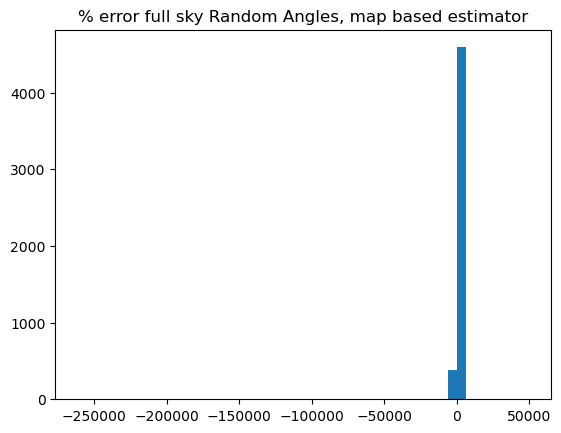

Median of full sky percent error: -1.1129414459574214
Mean of full sky percent error: -55.594879824038294
Std dev of full sky percent error: 3540.2486710929165


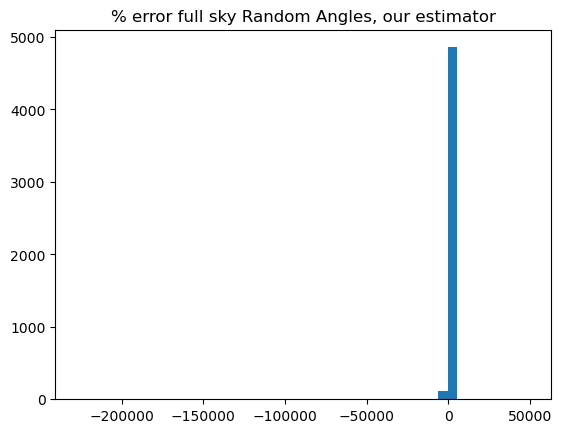

Median of full sky percent error EB estimator: -8.259009580140152
Mean of full sky percent error EB estimator: -683.6086033118091
Std dev of full sky percent error EB estimator: 31829.879392055533


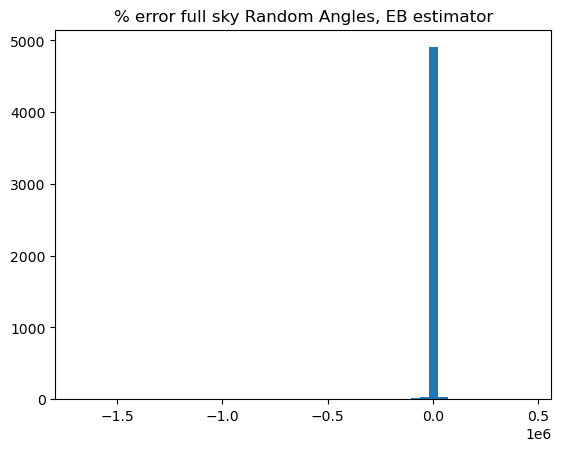

Median of full sky angles Unrot EB estimator: 0.0010001000100015034
Mean of full sky angles Unrot EB estimator: 7.6007600760085836e-06
Std dev of full sky angles Unrot EB estimator: 0.0018733510332355882


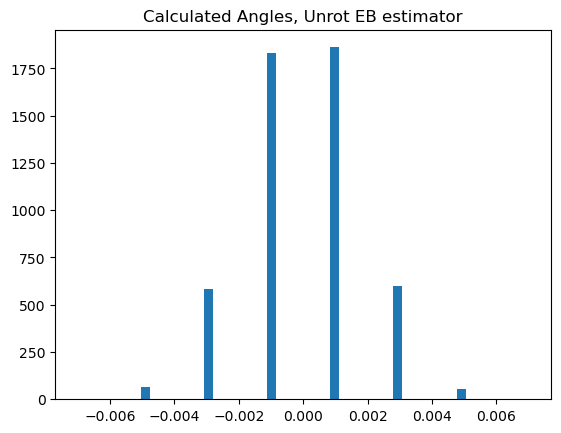

Median of full sky mean TT ratio: 1.000006295384088
Mean of full sky mean TT ratio: 1.000002598733517
Std dev of full sky mean TT ratio: 0.0016247719024242392


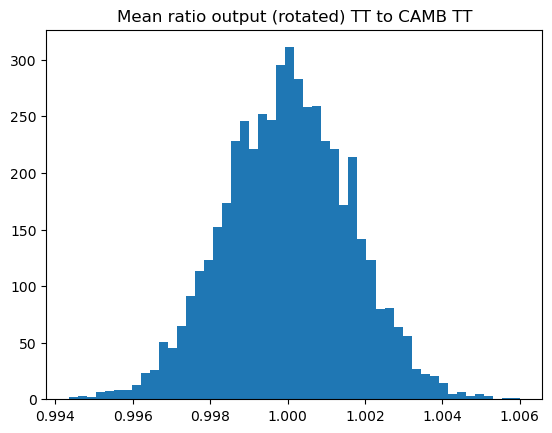

In [34]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky Random Angles, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky Random Angles, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky Random Angles, EB estimator")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

Median of full sky angles, our estimator: 0.06900069000690223
Mean of full sky angles, our estimator: -0.04839480394803849
Std dev of full sky angles, our estimator: 5.37544981169053


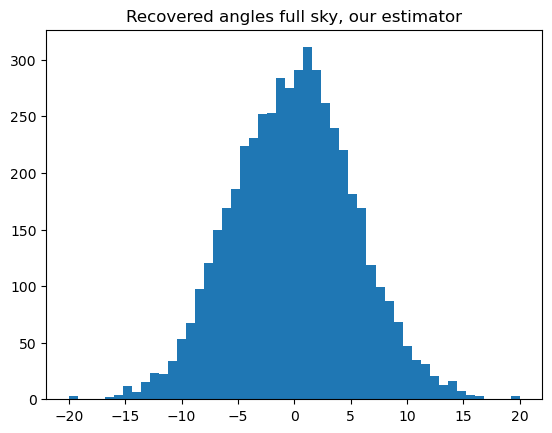

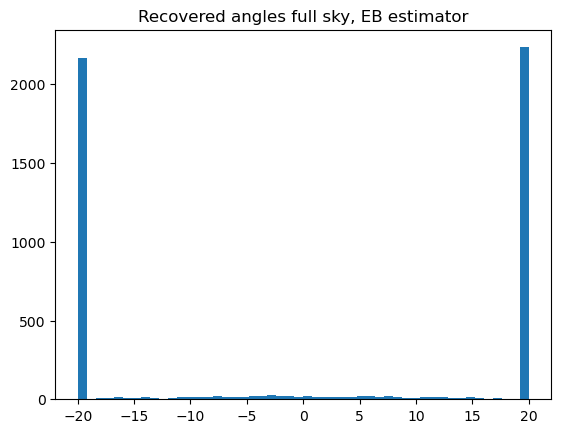

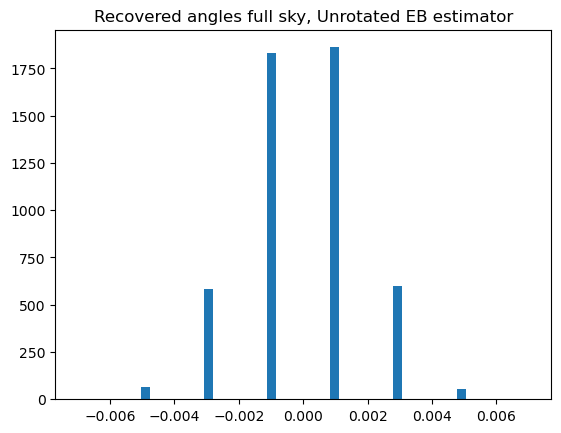

Median of full sky angles, map based estimator: 0.06405068595841736
Mean of full sky angles, map based estimator: -0.05088394488259253
Std dev of full sky angles, map based estimator: 5.188415636688481


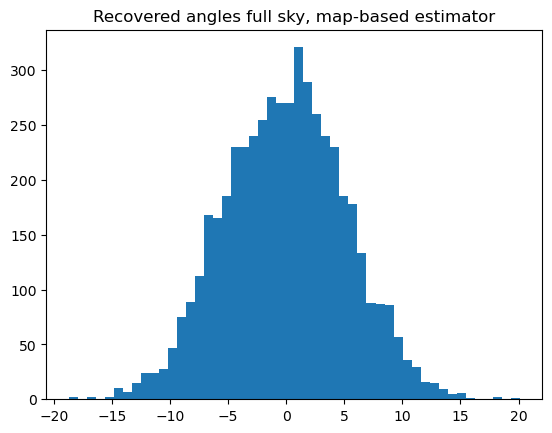

In [43]:
# Plotting the angles by themselves instead of percent difference
print("Median of full sky angles, our estimator: " + str(np.median(output_angles_only)))
print("Mean of full sky angles, our estimator: " + str(np.mean(output_angles_only)))
print("Std dev of full sky angles, our estimator: " + str(np.std(output_angles_only)))
plt.hist(output_angles_only,bins=50)
plt.title("Recovered angles full sky, our estimator")
plt.show()
plt.close()
plt.hist(output_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, EB estimator")
plt.show()
plt.close()
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, Unrotated EB estimator")
plt.show()
plt.close()
print("Median of full sky angles, map based estimator: " + str(np.median(output_mapspace_angles)))
print("Mean of full sky angles, map based estimator: " + str(np.mean(output_mapspace_angles)))
print("Std dev of full sky angles, map based estimator: " + str(np.std(output_mapspace_angles)))
plt.hist(output_mapspace_angles,bins=50)
plt.title("Recovered angles full sky, map-based estimator")
plt.show()
plt.close()

In [41]:
print(np.max(rot_degs))
print(np.min(rot_degs))
print(np.min(np.abs(rot_degs)))
print(percent_diff[np.where(rot_degs == np.min(np.abs(rot_degs)))[0]])

19.636298042151562
-17.3177847287008
0.0011858181226552128
[-226933.00641806]


Median of full sky percent error, map based estimator: -2.378816479617346
Mean of full sky percent error, map based estimator: -0.7131086702933874
Std dev of full sky percent error, map based estimator: 38.5424297901287


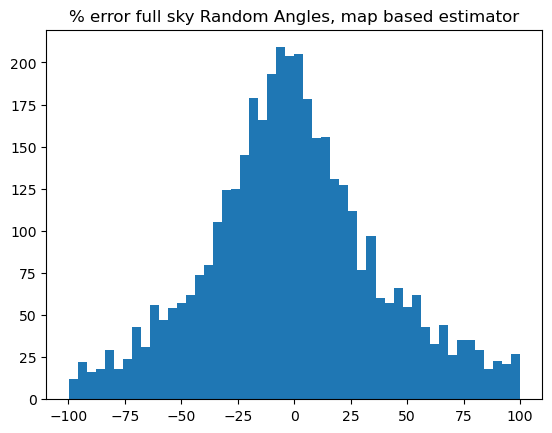

Median of full sky percent error: -1.6280863204192066
Mean of full sky percent error: -0.7150141187046037
Std dev of full sky percent error: 41.48801301795077


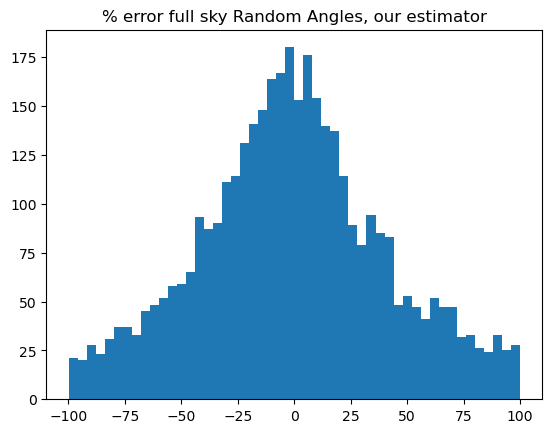

In [42]:
# Cutting out the big outliers
indices_no_outliers_mapbased = np.where(np.abs(mapbased_percent_diff)<100.0)[0]
indices_no_outliers_estimator = np.where(np.abs(percent_diff)<100.0)[0]
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff[indices_no_outliers_mapbased])))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff[indices_no_outliers_mapbased])))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff[indices_no_outliers_mapbased])))
plt.hist(mapbased_percent_diff[indices_no_outliers_mapbased],bins=50)
plt.title("% error full sky Random Angles, map based estimator")
plt.show()
plt.close()
print("Median of full sky percent error: " + str(np.median(percent_diff[indices_no_outliers_estimator])))
print("Mean of full sky percent error: " + str(np.mean(percent_diff[indices_no_outliers_estimator])))
print("Std dev of full sky percent error: " + str(np.std(percent_diff[indices_no_outliers_estimator])))
plt.hist(percent_diff[indices_no_outliers_estimator],bins=50)
plt.title("% error full sky Random Angles, our estimator")
plt.show()
plt.close()